# Visualizing a Hopfield RNN with Fovea

In this tutorial, we'll dig into the source of some of Fovea's machine learning backend and demonstrate how to use a Hopfield Network for the purposes of optical character recognition. While our example will be rudimentary in scope so as to avoid getting too bogged down in minutiae, the network used can be applied to an extensive variety of real-world scientific challenges.

## The Structure of Fovea's Machine Learning Utilities

Fovea comes packaged with a full-fledged implementation of a generic Hopfield network, a type of *Recurrent Neural Network*. RNNs are distinguishable from vanilla neural networks in that they allow for feedback between the component computational units, also called neurons. This gives the network an internal representation of *associative memory*, as we'll demonstrate in this example.

The network implementation code is contained in `retina/mlearn/hopfield_network.py`. The file defines a single class, `HopfieldNetwork`, which is easily instantiated by a single call of the form `myNet = HopfieldNetwork(num_neurons)`. Optionally, an activation can be supplied (more on this later). The `num_neurons` argument specifies the number of neurons to be used internally by the network.

The file `visuals.py` contains the front-end code that defines a `VisualHopfield` network built on top of the `HopfieldNetwork` backend. The `VisualHopfield` network also relies on an internal `VisualNeuron` class which creates drawings of neurons and the connections between them. In its default form, `VisualHopfield` runs a detailed visual simulation of the Hopfield network training and learning on whatever data it's supplied. That said, each component of the visualization can easily be separated from the action of the others should your needs require a customized approach.

## Understanding the Hopfield Network

In order to understand the Hopfield network's action, we must first understand its implementation. The network has three defining characteristics that separate it from other RNNs.

1. As in all neural networks, the connection between any two neurons is assigned some weight. In the case of the Hopfield network all connections are symmetric, i.e. for any two neurons $N_i$, $N_j$, we have $w_{ij} = w_{ji}$ where $w_{ij}$ and $w_{ji}$ are the weights of the connections between neurons $i$ and $j$ and neurons $j$ and $i$, respectively. What's more, each neuron is connected to every other neuron in the network, although not to itself.

2. The neurons in a Hopfield network are bipolar. That means that they have two possible output states: 1 if the sum of the input values to the neuron exceeds the threshold given by the network's activation function and -1 otherwise.

3. Because every Hopfield network is fully connected, we can associate with it a weight matrix which contains as the $ij^{\text{th}}$ entry the weight of the connection between $N_i$ and $N_j$. As a result of the properties enumerated above, this weight matrix is symmetric and consists of -1's and 1's with 0's along the diagonal (since $w_{ii} = 0 \quad \forall i$).

The natural question arising from this definition of the network is the following: How are the weights of the connections between individual neurons assigned?

### Training the Hopfield Network

Assigning weights to the connections of a neural network takes place during a process called "training" in which the network is fed input data having some well-defined set of features which the network would ideally learn. There are a number of different statistical models of learning that have been proposed and applied over the course of the neural network's development. Our Hopfield network implements the *Hebbian* learning rule and will support *Storkey* learning in the near future.

The Hebbian learning rule is one of the oldest learning models in existence, having been developed by Donald Hebb in 1949. It is based on a simple premise: that "neurons that fire together, wire together, [and] neurons that fire out of sync, fail to link." Formally speaking, the rule calculates the weight matrix as

$$W = \frac{1}{n} \sum_{i = 1}^{n} \mu_i \otimes \mu_i$$

Thus the network is presented with a set of $n$ vectors $\{\mu_1 \ldots \mu_n\}$ and sums the outer product of each vector with itself. 

## How the Network Responds to Input

After training, the network sports a well-defined weight matrix. Subsequently, when presented with an input vector the network generates an output vector based on this weight matrix. In our implementation, this occurs in the function `HopfieldNetwork.recall()`. The output vector is computed simply by multiplying the input vector by the weight matrix. In this way, the network applies its knowledge of the vectors it learned during training (encoded in the weight matrix) to its generation of an output. Broadly speaking, if the network is told to recall an input vector that it has already seen during training, it should output that very same vector. If the vector was not seen during training, the output should be an idealization of that vector based on the information that the network has seen. This desired behavior does not always occur due to the existence of a phenomenon called *spurious states* which we will touch on now.

## The Energy Function of a Hopfield Network

For each input (or state) vector $[s_1, \ldots, s_n]$ provided to our network, we can define the energy associated with that vector as
$$ E = -\frac{1}{2}\sum_{i,j} w_{ij}s_{i}s_{j}$$
It turns out that the action of the Hopfield Network can be completely inferred from the topology of this energy function. When plotted in $n+1$ dimensions, the energy function traces out an *energy landscape*. Like any bounded manifold, this landscape possesses a series of local minima. It can be proven mathematically that each of the input vectors provided to the network in training become one of these *attractor states*. Unfortunately, it is also the case that local minima exist which are not associated with the training vectors. These are the aforementioned *spurious states*. It is always the case that during the recall phase the network converges to the local minima closest to the input vector(s) provided. Therefore, if $d(i, s) < d(i, t_j) \quad \forall j$ where $s$ is some spurious state, each $t_j$ is a training state, and $d$ is a metric defined on your network's domain space, then the network will converge to a spurious state and not to one of the training states.

In the standard Hopfield network, such as the one that our code defines, the number of training vectors or states that the network is capable of remembering reliably is given by the formula

$$M = 0.15N$$

where $M$ is the number of preserved memories, and $N$ is the number of neurons in the network. Since, in general, we seek to preserve our training data as the attractors or "memories" of the network, we should take care to not exceed this upper bound on the number of training samples we provide. If this bound is exceeded, it turns out that attractor minima can merge into single, deeper minimums wherein spurious states are formed. For our tutorial, we will be training on the alphabet using a network composed of 25 neurons. Therefore, we will be able to reliably distinguish between at most three different letters.

## The Two Types of Update Processes

When a network is presented with an input vector to recall, it can proceed in one of two ways: via either synchronous or asynchronous updating of the network's internal state.

In *asynchronous updating*, each component of the input vector (i.e. each neuron) is updated independent of all other components. Since each of these updates occupies a single time step, subsequent updating can be affected by the results of previous updates. In our network, asynchronous updating is enabled by default as it guarantees that the network will converge to some attractor state. It is also what we will use throughout the course of this tutorial.

**Implementation Detail:** When implementing asynchronous updating in code, it is necessary at each time step to select (in a way which does not noticeably perturb the network's structure) a neuron to update. In our code, this is implemented as a random process which does not converge until each neuron has been updated. You will notice that as a result the recall phase of the network's operation will take somewhere between approximately 70 - 120 iterations to finish. If you are visualizing this process, there will be noticeable periods of apparent inactivity where the network's energy configuration does not change. This means that the network is randomly selecting and updating neurons that have already been updated.

In *synchronous updating*, all components of the input vector (neurons) are updated in tandem. Naturally, this method has time complexity benefits when compared to asynchronous updating; however, when synchronous updating is used, the network is not guaranteed to converge to a stable state. Our network also supports synchronous updating.

## Visualizing the Network

Now that you know the basic theory behind the Hopfield network's operation, lets turn to the task of visualizing these networks using Fovea. The visualization code is contained in the `retina.mlearn.hopfield` module in the file `visuals.py`. This file defines two classes: `VisualNeuron` and `VisualHopfield`.

## The `VisualNeuron` Class

The simpler of the two classes is `VisualNeuron`. All calls to `VisualNeuron` are hidden internally within `VisualHopfied`, and it is unlikely that you will need to alter this class. That said, if you do decide to adjust the visualization of individual neurons to your own specifications you will need to be familiar with the following class functions.

`__init__(self, r, theta)`: In our construction, a `VisualNeuron` is instantiated with a pair of polar coordinates $(r, \theta)$. Within the `__init__` method, these coordinates are converted to Cartesian form and stored as the instance variables `self.x` and `self.y`.

`draw(self, axis)`: This method takes a single argument, namely the Matplotlib axs to which the neuron's visual representation should be drawn. The function creates a neuronal "body" using the Matplotlib `Circle` patch centered at the coordinates `(self.x, self.y)`. You can change the patch class used, or provide an artist instance of your own should you prefer a different visual representation of each node in the network.

`draw_connection(self, neuron, connection_color, axis)`: This function takes another `VisualNeuron` instance and draws a line having the specified `connection_color` between the two. Internally, the Matplotlib `Line2D` class is used, but of course you can make any alterations you see fit.

`delete_connection(self, neuron)`: As in the above, this function takes a `VisualNeuron` instance and deletes the connection between the two. This deletion is two-fold. It occurs at the visual level on the connection's axes and at the object-state level. Neither the calling neuron, nor the argument neuron, will be able to access a connection's attributes after it has been deleted.

## `The VisualHopfield` Class

We will now dissect, function by function, the operation of the `VisualNeuron` class. The core event loop for the default network visualization is contained in the method `run_visualization`. Let's take a look at its contents.

```
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            ion()
            self.training_data = training_data
            self.recall_data = recall_data
            self._setup_display()
            self._draw_network()
            self._plot_state([-1 for i in range(self.num_neurons)])
            self._plot_weights()
            print("Training...")
            self._set_mode("Training")
            self.train(training_data, inject=self._train_inject)
            self._normalize_network()
            self._plot_energy()
            print("Recalling...")
            self._set_mode("Recalling")
            for state in learning_data:
                self.recall([state], inject=self._recall_inject)
```

We will ignore the code dealing with warnings. These lines just suppress annoying command-line output associated with deprecations involving interactive drawing methods provided by the Matplotlib backends. Therefore, the first relevant line is `self._setup_display()`. Let's jump to the private `_setup_display` method and investigate its action.

## The `_setup_display` Function

The task of the `_setup_display` function is to construct the Matplotlib figure window and arrange its component axes. The figure is assigned to the instance attribute `self.network_fig` and can be accessed as such. The component axes are the following:

```
        self.main_network    --  Axes to which VisualNeurons and their connections are drawn.
        self.energy_diagram  --  The 3D axes in which the network's energy function is plotted.
        self.contour_diagram --  Axes to hold the contour plot of the network's energy function.
        self.state_diagram   --  Axes to which a checkerboard representation of the network's binary state is drawn.
        self.weight_diagram  --  Axes to hold a heatmap representation of the network's weight matrix.
```

The function also creates widgets to toggle layer visibility in the energy diagram and dynamic text labels that change based on the network's current mode (training or recalling) and iteration count within those methods.

## The `_draw_network` Function

This method uses a simple loop to draw the symmetric connections that occur between each of the network's neurons. Probably the most useful information that can be gleaned from the function is the significance of a connection's color. In our setup, connections having the weight 0 are colored green, the weight 1 colored blue, and the weight -1 colored red. You can change these colors to suit your preferences by altering the variable `colors`.

## The `_plot_state` Function

This method handles all of the plotting necessary for creating the network's state diagram. The network's "state" at any given point in time is the output of its recall function in response to an input vector. Since all network vectors are bipolar, we split its output vector at even intervals and use these vectors as the rows of a matrix. This matrix is converted to a black-and-white patchwork diagram using Matplotlib's `imshow` function.

**IMPORTANT:** Each state is a numpy array, and is converted to a matrix using the `state.reshape()` function. You will need to alter this call should you seek to visualize a network not having exactly 25 neurons as is used for the OCR example.

## The `_plot_weights` Function

This one is similar to `_plot_state` in its action and construction. The `imshow` map is used to create a colormap representation of the network's weight matrix. You can modify this method to change the colormap used.

## The `_set_mode` Function

Updates the network's "mode" text label based on the network's current operation: either training or recalling.

## The `_train_inject` Function

This function contains visualization code that is injected into the `HopfieldNetwork` base class' training method. Alter with care.

## The `_recall_inject` Function

Same as above, except for the network's recalling method. Alter with care, as well.

## The `_normalize_network` Function

This method serves one purpose: resetting the linewidth of those neuronal connections that were manipulated by the network during its training phase so as not to pollute with thickness the visual space.

## The `_plot_energy` Function

The `_plot_energy` function is probably the most involved method of the entire visualization, as there is a great deal of legwork that goes into creating a 3-dimensional representation of the energy landscape. For networks having $\geq 3$ neurons, the plot of the energy function will reside in 4 or more dimensions. In order to reduce this $n$-dimensional information to a 3-dimensional representation, we perform a 2D PCA transformation on the network's training data. If we treat these PCA axes as our x and y axes and the energy value as the z-axis, we are able to plot the energy function accordingly.

This function, in fact, contains three plot artists in three different layers. The first layer contains the network's attractors, plotted in a scatter plot as green markers. The second layer contains a wireframe plot of the energy landscape onto which the attractor markers can be overlaid. The third layer contains the energy landscape plotted as a surface.

# Visualizing Optical Character Recognition

Now that we've fully described both the `HopfieldNetwork` and `VisualHopfield` classes, let's turn our attention to the OCR example packaged in the `demos/hopfield` directory.

The network makes the following imports:

```
from retina.mlearn.hopfield.alphabet import *
import retina.mlearn.hopfield.visuals as visuals
import numpy as np
```

Hopefully, the only one of these needing explanation is the import involving the file `alphabet.py`. This file contains a series of variable definitions corresponding to each of the 26 letters of the English alphabet. Each variable holds a string corresponding to a 5x5 binary representation of its character. For example, here is a sample assignment taken from the file:

```
F = """
XXXXX
X....
XXXXX
X....
X....
"""
```

The `ocr.py` file defines a function, `to_state`, which takes a letter's string representation and converts it to a binary vector which the hopfield network can use as either training or recall data. The string is flattened into a 1x25 array of X's and .'s and each of these is mapped to the values 1 and -1, respectively. As an example, F as given above would map to:

`[1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1]`

The OCR script converts each of the 26 letters to the above format, and then provides them to the Hopfield Network as training data. It then takes the letter `l1` (also defined in `alphabet.py`) and passes it as input to the network's recall method. This letter looks most similar to the letter A, and the network should (ideally) recognize it as such.

Now, let's take a look at each Axes of the visualization independently and see how we can use these diagrams to inform our understanding of the theoretical properties of the network.

## The Network Diagram

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [4]:
# %load ocr.py
from retina.mlearn.hopfield.alphabet import *
import retina.mlearn.hopfield.visuals as visuals
import numpy as np

def to_state(letter):
    return np.array([1 if char == 'X' else -1 for char in letter.replace('\n','')])

myNet = visuals.VisualHopfield(25)
alphabet = [A, B, C, D, E, F, G, H, I, J, K, L, M, 
        N, O, P, Q, R, S, T, U, V, W, X, Y, Z]
training_data = [to_state(letter) for letter in alphabet]
recall_data = [to_state(l1)]

<IPython.core.display.Javascript object>


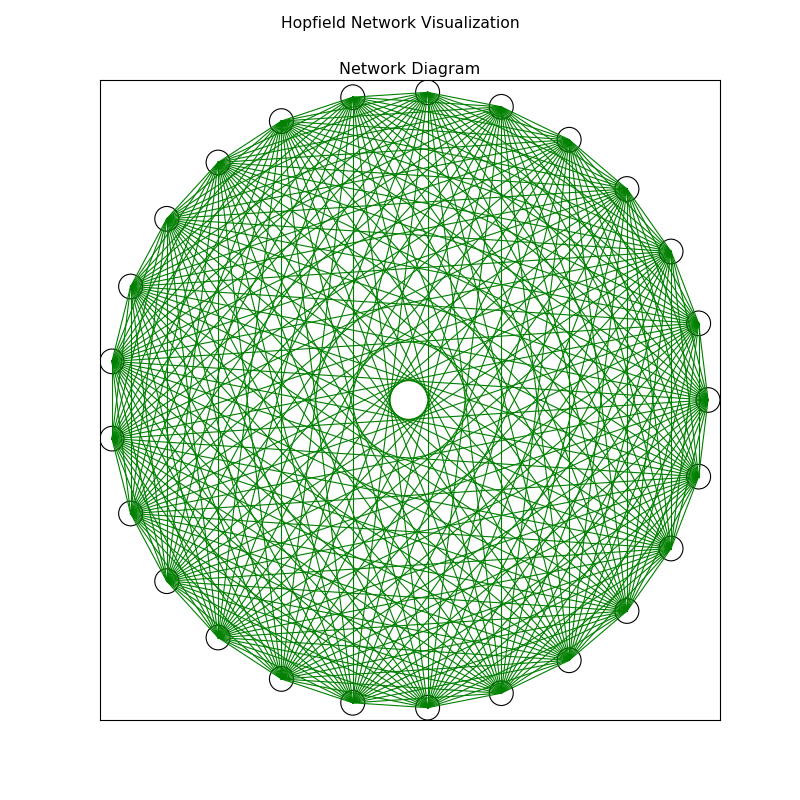

In [5]:
myNet.network_fig = plt.figure(figsize=(10, 10))
myNet.network_fig.canvas.set_window_title("Hopfield Network Visualization")

myNet.main_network = plt.subplot(111)
myNet.main_network.set_title("Network Diagram")
myNet.main_network.get_xaxis().set_ticks([])
myNet.main_network.get_yaxis().set_ticks([])

myNet.network_fig.suptitle("Hopfield Network Visualization", fontsize=14)

myNet._draw_network()

Above we see the network's 25 neurons, each connected to every other, arranged in a circle. Before training has started the weight of each connection defaults to zero, as is pictured above (green = 0).

Now, let's provide a training vector and watch the network's state connections adapt in response.

myNet.train(to_state(B))

You should see the connections between neurons change such that the final configuration of the network looks like this

![Network After Training](imgs/network_diagram.png)

As in our discussion of the `_draw_network` function, blue lines represent connections having weight 1 and red lines those having weight -1.

## The Weight Matrix Diagram

Now, if you turn your attention to the network's weight matrix diagram, you should see an image that looks like this:

![Weight Matrix Diagram](imgs/weight_matrix.png)

Upon closer inspection, you can see that the color map really highlights the symmetry of the weight matrix. Every column color pattern in this diagram is identical to that of its correspondingly numbered row, an example of which I've bounded in red, below:

![Weight Matrix Symmetry](imgs/weight_matrix_symmetry.png)

Of course, yellow blocks of pixels indicate an entry of -1 in that position, and purple blocks of pixels indicate an entry of 1.

## The State Diagram

Now, let's train our network on the letters B and I, and then tell it to recall the following letter:

```
shift_I = """
XXXXX
...X.
...X.
...X.
XXXXX
"""
```

We would hope that our network recognizes this as the letter I and converges to that state. Let's see what output we get from our state diagram at the end of the recall process:

![Network State Diagram](imgs/state_diagram.png)

It is indeed the case that our network converges to the expected state, the letter I!

## The Energy Function Diagram

Now, let's try to better understand the action of this convergence by looking to our network's energy function diagram. When recall starts, the landscape is plotted as a mesh surface with areas of low energy colored blue and higher energy colored red. It should look more or less like this:

![Energy Mesh Surface](imgs/energy_mesh.png)

As explained in our previous exposition of the network's theoretical properties, the states on which the network trained should be attractors and lie at some local minima of this landscape. However, the network's landscape is varied and complex, and it's not immediately clear at which local minima our attractors should reside. Luckily, Fovea does the computation for you. In order to see the plotted attractors, we need to click both the "Wireframe" and Attractors" buttons. The wireframe button toggles the visibility of both the mesh surface and wireframe layers, switching one off and the other on. In this case, we want to view the opaque wireframe as it will prevent the attractor markers from being covered by the mesh surface. We also click the attractors button in order to see the energies of our original states marked as green dots. When you do this, you will see a blue marker in addition to the green ones. This marker indicates the energy value of the network's current state. This is what the diagram looks like when the wireframe and attractors are shown together:

![Stage 1](imgs/1.png)

As you can see below, our energy landscape has our two attractor states positioned at the lowest possible energy levels along with the network's current state positioned near a peak of the landscape. You can also see that there is a rift between the two minima wherein the global maximum is attained. The reasons for this topology are the following:

1. The two states upon which the data were trained are highly dissimilar in presentation.
2. As such, only a great deal of "energy" could take attractor B, move it over the global maximum, and transmute it to attractor I, and vice versa.

As you can see, our recall state initially rests near the top of a peak located close to the "I" attractor. Over the course of the recall process, the blue current state marker will fall from this peak and ultimately converge to the energy value of its final state, I. This progression is shown below.

![Stage 2](imgs/2.png)

![Stage 3](imgs/3.png)

![Stage 4](imgs/4.png)

![Stage 5](imgs/5.png)

## The Energy Contour Diagram

The last, and in this case probably least, part of the visualization is the contour diagram. This provides a simple, 2D contour plot of the 3-dimensional energy landscape. Shown below is an energy function and its corresponding contour drawing.

![Contour Plot](imgs/contour.png)

# Conclusion

And there you have it, a full-scale visualization of a Hopfield RNN created using Fovea's machine learning package. I hope you found this tutorial enlightening and that it informed more fully your understanding of the Hopfield network and how it responds to data. Until next time.